In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from utils.path import WildcardPath
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import alignment.ensemble
import alignment.dataset
import utils.plots
from alignment.dataset import Dataset
from alignment.alignment import Alignment
from features.unaligned import DatasetFeatureExtractor
from Bio import SeqIO, AlignIO
from pypythia.custom_types import FileFormat
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import tempfile
from tqdm import tqdm
from utils.general import infer_data_type
from multiprocessing import Pool

In [2]:
DATA_DIR = WildcardPath("/hits/fast/cme/bodynems/data/")
RESULT_DIR = WildcardPath("/hits/fast/cme/bodynems/MSA_difficulty/results")
INPUT_DIR = DATA_DIR / "input" / "{benchmark}"
DATASET_DIR = INPUT_DIR / "{dataset}"
STATS_DIR = RESULT_DIR / "treebase" / "stats"

In [ ]:
def process_dataset(file_name: str) -> dict:
    out_dict = {}
    alignment = None
    valid_chars = np.array([char for char in "-ACDEFGHIKLMNPQRSTVWY"])
    try:
        alignment = Alignment(benchmark_dir / file_name, file_format=FileFormat.PHYLIP)
        msa_arr = pd.DataFrame(alignment.msa)
        contains_void_seqs = (
            (msa_arr == "-").all(axis=1) | (msa_arr == "N").all(axis=1)
        ).any()
        if contains_void_seqs:
            out_dict["excluded"] = "void_sequence"
        infer_data_type
        all_valid_chars = msa_arr.isin(valid_chars).all(axis=None)
        if not all_valid_chars:
            out_dict["excluded"] = "bad_chars"
    except:
        out_dict["excluded"] = "broken"

    if "excluded" not in out_dict:
        records = []
        site_count = 0
        for aligned_seq in alignment.msa:
            raw_seq = Seq(str(aligned_seq.seq).replace("-", ""))
            site_count += len(raw_seq)
            records.append(SeqRecord(raw_seq, id=aligned_seq.id))
        inv_inflation_ratio = 1 - site_count / (len(aligned_seq.seq) * len(records))
        with tempfile.NamedTemporaryFile() as tmp_file:
            tmp_path = WildcardPath(tmp_file.name)
            SeqIO.write(records, tmp_path, format="fasta")
            try:
                dataset = Dataset(tmp_path)
            except Exception as e:
                out_dict["excluded"] = "broken"

    if "excluded" not in out_dict:
        out_dict["file_name"] = file_name
        out_dict["num_taxa"] = len(dataset.sequences)
        out_dict["max_len_taxa"] = max(dataset._sequence_lengths)
        out_dict["inv_inflation_ratio"] = inv_inflation_ratio
        out_dict["data_type"] = str(dataset.data_type)
        # exclude = [
        #     DatasetFeatureExtractor._pairwise_alignments,
        #     DatasetFeatureExtractor._sequence_shannon_entropy,
        #     DatasetFeatureExtractor._kmer_similarity,
        #     DatasetFeatureExtractor._perc_seq_hash_hamming_distance,
        # ]
        # extractor = DatasetFeatureExtractor(dataset, threads=1)
        # feats = extractor.compute(exclude=exclude)
        # feats["file_name"] = file_name

    return out_dict


benchmark_dir = WildcardPath("/hits/fast/cme/TreeBase")
with Pool(16) as pool:
    out_dicts = pool.map(process_dataset, benchmark_dir.listdir(suffix=".phy"))

In [ ]:
stats = pd.DataFrame(out_dicts)
print("Number of datasets:", len(stats))
print()
print(stats.excluded.value_counts())
print()
print(stats.data_type.value_counts())

os.makedirs(STATS_DIR, exist_ok=True)
stats = stats[stats["excluded"].isna()].drop("excluded", axis=1).reset_index(drop=True)
# stats.to_pickle(STATS_DIR / "raw.pkl")

In [3]:
stats_file = STATS_DIR / "raw.pkl"
stats = pd.read_pickle(stats_file)
print(stats.describe().round(2))

       num_taxa  max_len_taxa  inv_inflation_ratio
count   9296.00       9296.00              9296.00
mean      67.47       6806.92                 0.15
std       86.09      60397.82                 0.16
min        4.00         21.00                 0.00
25%       25.00        599.00                 0.02
50%       46.00       1083.00                 0.09
75%       79.00       2307.00                 0.22
max     2356.00    2969062.00                 0.97


In [4]:
q_cut_df = stats.drop("file_name", axis=1).groupby("data_type").quantile(0.95)
print("Cutoff values:")
q_cut_df

Cutoff values:


,num_taxa,max_len_taxa,inv_inflation_ratio
data_type,,,
AA,234.1,46024.9,0.638240
DNA,185.0,8255.5,0.469165


In [8]:
from utils.enums import DataTypeEnum

stats_clean = []
data_lim = 10000
for data_type in DataTypeEnum:
    type_mask = stats.data_type == data_type
    q_cuts = q_cut_df.loc[str(data_type)].to_dict()
    query = " & ".join([f"{key}<={val}" for key, val in q_cuts.items()])
    clean_df = stats[type_mask].query(query)
    print(clean_df.shape)
    clean_df = clean_df[clean_df["max_len_taxa"] < data_lim]
    print(clean_df.shape)
    stats_clean.append(clean_df)
    print(
        f"{data_type}: Dropped {(sum(type_mask) - len(clean_df)) / sum(type_mask):.2%}."
    )

stats_clean = pd.concat(stats_clean, axis=0, ignore_index=True)

stats_clean.drop("file_name", axis=1).groupby("data_type").aggregate(
    ["min", "max"]
).round(2)

(7355, 5)
(7355, 5)
DNA: Dropped 13.33%.
(699, 5)
(640, 5)
AA: Dropped 20.99%.


num_taxa        max_len_taxa         inv_inflation_ratio      
               min    max          min     max                 min   max
data_type                                                               
AA             4.0  233.0         23.0  9975.0                 0.0  0.63
DNA            4.0  185.0         21.0  8175.0                 0.0  0.47

In [9]:
print(stats_clean.groupby("data_type").count())

           file_name  num_taxa  max_len_taxa  inv_inflation_ratio
data_type                                                        
AA               640       640           640                  640
DNA             7355      7355          7355                 7355


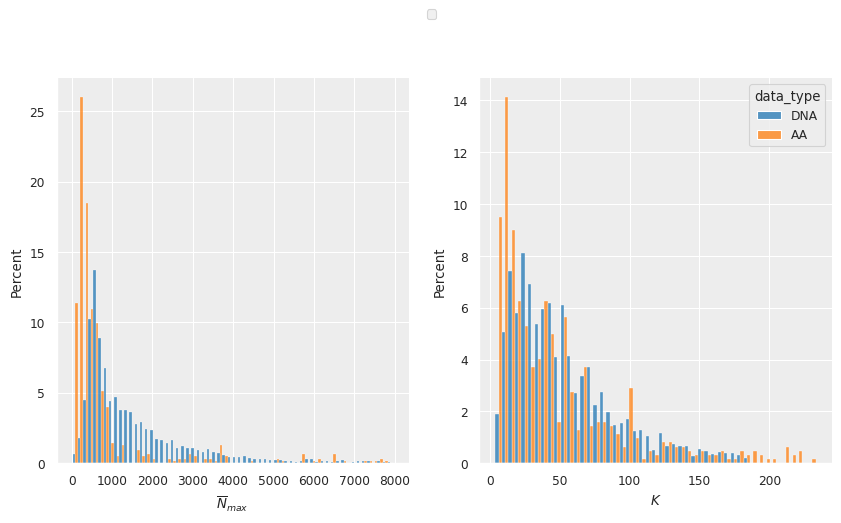

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(
    stats_clean,
    x="max_len_taxa",
    hue="data_type",
    multiple="dodge",
    stat="percent",
    common_norm=False,
    ax=axes[0],
)
axes[0].set_xlabel("$\overline{N}_{max}$")
# axes[0].set_title("M")
sns.histplot(
    stats_clean,
    x="num_taxa",
    hue="data_type",
    multiple="dodge",
    stat="percent",
    common_norm=False,
    ax=axes[1],
)
axes[1].set_xlabel("$K$")
legend_labels = axes[0].get_legend_handles_labels()[1]
plt.figlegend(
    axes[0].get_legend_handles_labels()[0],
    legend_labels,
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.03),
)
axes[0].get_legend().remove()

In [55]:
# Save all cleaned datasets
all_file = STATS_DIR / f"cleaned_v2.pkl"
stats_clean.to_pickle(all_file)

# Save DNA and protein individually
for data_type in DataTypeEnum:
    filtered_file = STATS_DIR / f"{str(data_type).lower()}.pkl"
    filtered = stats[stats.data_type == data_type].reset_index(drop=True)
    filtered.to_pickle(filtered_file)

In [56]:
stats_clean.groupby("data_type").count()

,file_name,num_taxa,max_len_taxa,inv_inflation_ratio
data_type,,,,
AA,622,622,622,622
DNA,7343,7343,7343,7343


In [10]:
samples = {}
sample_sizes = {"DNA": 400, "AA": 400}
for data_type in DataTypeEnum:
    filtered = stats_clean[stats_clean.data_type == data_type].reset_index(drop=True)
    weight_cols = ["num_taxa", "max_len_taxa"]
    eps = 1e-4
    weights = filtered[weight_cols]
    weights = np.abs(weights - weights.min(0)) + eps
    weights = weights.prod(axis=1)
    weights /= weights.sum()
    sampled = filtered.sample(
        sample_sizes[data_type], weights=weights, random_state=0, ignore_index=True
    )

    samples[data_type] = sampled
    # sampled_file = STATS_DIR / f"{str(data_type).lower()}_sampled.pkl"
    # sampled.to_pickle(sampled_file)

samples_df = pd.concat(samples.values(), axis=0)
sampled_file = STATS_DIR / f"sampled_v2.pkl"
samples_df.to_pickle(sampled_file)
samples_df.drop("file_name", axis=1).groupby("data_type").aggregate(
    ["min", "max"]
).round(2)

num_taxa        max_len_taxa         inv_inflation_ratio      
               min    max          min     max                 min   max
data_type                                                               
AA             6.0  233.0         34.0  9975.0                 0.0  0.63
DNA            7.0  185.0        253.0  8157.0                 0.0  0.47

In [64]:
samples_df.inv_inflation_ratio.describe()

count    3122.000000
mean        0.152986
std         0.136757
min         0.000000
25%         0.035117
50%         0.116582
75%         0.243424
max         0.634400
Name: inv_inflation_ratio, dtype: float64

/tmp/ipykernel_1604295/2104528741.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="upper right")
/tmp/ipykernel_1604295/2104528741.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend().remove()


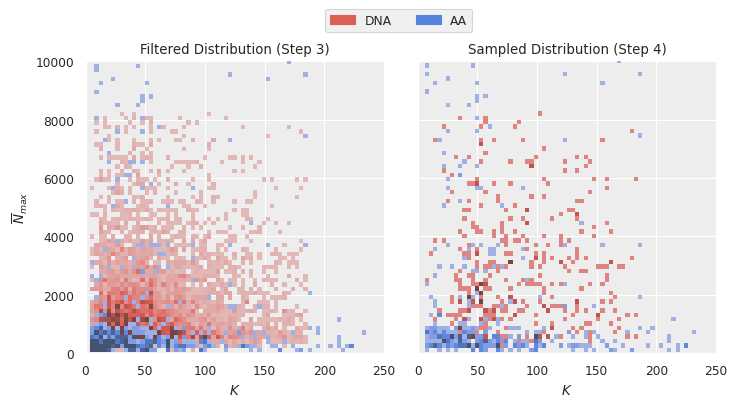

In [13]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3.5))
fig.tight_layout()
colors = sns.color_palette("hls", 10)
colors = [colors[0], colors[6]]
bin_scales = (3.5, 150)
sns.histplot(
    stats_clean,
    x="num_taxa",
    y="max_len_taxa",
    hue="data_type",
    # style="data_type",
    ax=axes[0],
    palette=colors,
    common_norm=False,
    # s=15,
    # alpha=0.6,
    pmax=0.7,
    # binwidth=(2, 0.5),
    binwidth=bin_scales,
    # bw_adjust=0.5,
)
axes[0].set_ylabel("$\overline{N}_{max}$")
axes[0].set_xlim(0, 250)
axes[1].set_xlim(0, 250)
axes[0].set_ylim(0, 10000)
axes[1].set_ylim(0, 10000)
axes[0].set_title("Filtered Distribution (Step 3)")
sns.histplot(
    samples_df,
    x="num_taxa",
    y="max_len_taxa",
    hue="data_type",
    element="poly",
    pmax=0.95,
    # style="data_type",
    palette=colors,
    ax=axes[1],
    common_norm=False,
    # s=15,
    # alpha=0.8,
    binwidth=bin_scales,
    # bw_adjust=0.5,
)
axes[0].set_xlabel("$K$")
axes[1].set_xlabel("$K$")
axes[1].set_title("Sampled Distribution (Step 4)")
axes[1].legend(loc="upper right")
axes[1].legend().remove()
sns.move_legend(
    axes[0],
    "upper center",
    # numpoints=5,
    markerscale=2.5,
    bbox_to_anchor=(1.05, 1.2),
    title="",
    # frameon=True,
    # fancybox=True,
    ncols=2,
)
fig.savefig(
    RESULT_DIR / "treebase" / "dataset_size_distributions.svg",
    bbox_inches="tight",
)

In [66]:
num_samples = len(samples_df)
# Sort by max_len_taxa first
sorted_df = samples_df.sort_values(
    ["max_len_taxa", "num_taxa"], ascending=True, ignore_index=True
)
sampled_small = sorted_df.groupby("data_type").head(num_samples // 4)
sampled_large = sorted_df.drop(sampled_small.index, axis=0)

# Save sampled file names
sampled_file = RESULT_DIR / "treebase" / "stats" / "sampled_small_v2.pkl"
sampled_small.to_pickle(sampled_file)
sampled_file = RESULT_DIR / "treebase" / "stats" / "sampled_large_v2.pkl"
sampled_large.to_pickle(sampled_file)

print(sampled_small.aggregate(("min", "max")))
print(sampled_large.aggregate(("min", "max")))

       file_name  num_taxa  max_len_taxa  inv_inflation_ratio data_type
min  10000_0.phy       4.0          23.0               0.0000        AA
max   9999_0.phy     233.0        7773.0               0.6344       DNA
       file_name  num_taxa  max_len_taxa  inv_inflation_ratio data_type
min  10001_0.phy       5.0        1143.0             0.000000       DNA
max   9994_1.phy     185.0        7954.0             0.469163       DNA


In [67]:
sampled_test = samples_df.groupby("data_type").sample(3, random_state=0)

# Save sampled file names
sampled_file = RESULT_DIR / "treebase" / "stats" / "test_v2.pkl"
sampled_test.to_pickle(sampled_file)

sampled_test

,file_name,num_taxa,max_len_taxa,inv_inflation_ratio,data_type
389,22027_0.phy,23.0,626.0,0.377978,AA
458,18113_26.phy,9.0,252.0,0.054066,AA
436,18113_4.phy,18.0,212.0,0.361934,AA
1490,12009_0.phy,88.0,3764.0,0.316416,DNA
1363,19731_1.phy,65.0,4090.0,0.420485,DNA
290,18509_1.phy,60.0,1920.0,0.242771,DNA


In [68]:
sampled_test_large = (
    samples_df.sort_values(
        ["max_len_taxa", "num_taxa"], ascending=False, ignore_index=True
    )
    .groupby("data_type")
    .first()
)

# Save sampled file names
sampled_file = RESULT_DIR / "treebase" / "stats" / "test_large_v2.pkl"
sampled_test_large.to_pickle(sampled_file)

sampled_test_large

,file_name,num_taxa,max_len_taxa,inv_inflation_ratio
data_type,,,,
AA,10454_1.phy,60.0,7773.0,0.139123
DNA,20397_0.phy,55.0,7954.0,0.385270


In [69]:
sampled_test_small = (
    samples_df.sort_values(
        ["max_len_taxa", "num_taxa"], ascending=False, ignore_index=True
    )
    .groupby("data_type")
    .tail(5)
)

# Save sampled file names
sampled_file = RESULT_DIR / "treebase" / "stats" / "test_small_v2.pkl"
sampled_test_small.to_pickle(sampled_file)

sampled_test_small

,file_name,num_taxa,max_len_taxa,inv_inflation_ratio,data_type
2951,378_0.phy,17.0,222.0,0.042925,DNA
2960,12354_1.phy,26.0,217.0,0.000000,DNA
2999,12689_21.phy,16.0,193.0,0.000000,DNA
3003,10264_3.phy,39.0,187.0,0.000000,DNA
3062,15822_0.phy,89.0,126.0,0.096414,DNA
3117,15931_6.phy,52.0,34.0,0.000000,AA
3118,15931_8.phy,52.0,34.0,0.000000,AA
3119,15931_5.phy,52.0,34.0,0.000000,AA
3120,22408_13.phy,9.0,32.0,0.263492,AA
3121,11210_2.phy,74.0,23.0,0.003525,AA
